# Import Libraries

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git > None # None чтобы не видеть огромного вывода, что библиотека загружается

  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-f0i0q7xo


In [ ]:
import torch
from kan import KAN

import random
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

**Эту ячейку запускать обязательно всегда перед началом работы, иначе значения гиперпараметров и самих метрик будут скакать даже при одинаковых цифрах**

In [ ]:
# Фиксация случайных начальных условий
def seed_everything(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1984)

# Data Preparation

In [ ]:
df = pd.read_csv("/content/bias_param_0507_OUT.csv")

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1']) # удалим столбцы с индексами
df.info() # должеы быть столбцы от 0 до 37

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   area/volume                                 979 non-null    float64
 1   h_range_max_koe                             979 non-null    float64
 2   Tc                                          979 non-null    float64
 3   temperature_k                               979 non-null    float64
 4   sat_em_g                                    979 non-null    float64
 5   coer_oe                                     979 non-null    float64
 6   mr (emu/g)                                  979 non-null    float64
 7   exc_bias_oe                                 979 non-null    float64
 8   exc_dir                                     979 non-null    float64
 9   ver_shift_emu_g                             979 non-null    float64
 10  ver_s_dir     

In [ ]:
# Проверим данные
df.describe()

,area/volume,h_range_max_koe,Tc,temperature_k,sat_em_g,coer_oe,mr (emu/g),exc_bias_oe,exc_dir,ver_shift_emu_g,...,core_sum_vec,core_sum_work_function,shell_sum_vec,shell_sum_work_function,core_pauling_electronegativity_difference,core_vec_difference,core_work_function_difference,shell_pauling_electronegativity_difference,shell_vec_difference,shell_work_function_difference
count,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,...,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,9.790000e+02,979.000000
mean,0.218317,36.457692,788.942901,72.999387,415.698464,2279.340897,13.128177,318.628186,0.141502,1.259763,...,698.794157,270.812372,539.941647,176.314782,2.290421,1.526309,8.942621,2.255265,1.511955e+00,8.086343
std,0.253926,23.634419,349.454907,110.867074,4974.751928,4053.992359,18.173922,405.794171,0.343329,4.774476,...,173.442290,147.822071,307.302545,124.118630,1.602428,1.355539,6.540183,1.502012,1.309873e+00,5.453118
min,0.003000,0.100000,30.000000,1.800000,0.000087,0.600000,0.000027,0.007500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.220446e-16,0.000000
25%,0.079302,20.000000,643.000000,5.000000,7.245000,316.500000,0.560000,31.500000,0.000000,0.000000,...,621.428600,180.000000,400.000000,89.500000,0.052172,0.000000,0.117858,0.079156,-2.220446e-16,0.000000
50%,0.150000,30.000000,809.800000,10.000000,26.353000,844.300000,6.200000,127.295000,0.000000,0.067000,...,700.000000,216.428600,683.166700,201.428600,2.860376,1.495174,10.000000,2.859813,1.443376e+00,10.000000
75%,0.253787,50.000000,860.000000,100.000000,50.550000,2188.424500,20.225000,473.310000,0.000000,0.929785,...,800.000000,470.000000,750.000000,250.000000,3.128237,2.500000,12.247450,2.932331,2.037707e+00,11.547010
max,2.000000,100.000000,1661.000000,608.000000,106600.000000,59144.000000,247.960000,1670.900000,1.000000,111.360000,...,1000.000000,515.000000,1000.000000,515.000000,11.547010,11.547010,29.495760,7.071068,7.071068e+00,26.291040


In [ ]:
target_column_name = "exc_bias_oe" # Обменный сдвиг коэрцитивной силы относительно намагниченности

X = df[list(df.columns.drop([target_column_name]))]
y = df[target_column_name]

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Применение к целевой переменной
y_smooth = gaussian_filter1d(y, sigma=2)  # Настройте sigma для изменения

# Логарифмирование целевой переменной
y_log = np.log10(y_smooth)

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=1984)

# Замена нулевых значений в целевом массиве на очень маленькое значение перед логарифмированием
#y_train[y_train == 0] = 1e-5 # Эксперимент
#y_test[y_test == 0] = 1e-5

# Нормализация дескрипторов
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Логарифмирование целевого значения
#y_train = np.log10(y_train)
#y_test = np.log10(y_test)

# Преобразование данных в тензоры PyTorch
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32) #().to_numpy
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32) #().to_numpy

In [ ]:
print("Диапазон значений целевых до логарифмирования: ", (np.min(y), np.max(y)))
print("Диапазон значений целевых после логарифмирования: ", (np.min(np.log10(y)), np.max(np.log10(y))))

Диапазон значений целевых до логарифмирования:  (0.0074999999999931, 1670.9)
Диапазон значений целевых после логарифмирования:  (-2.1249387366086996, 3.2229504590210114)


In [ ]:
# Вывод форм данных для проверки, чтобы проверить размеры
print("Train input shape:", train_input.shape)
print("Train label shape:", train_label.shape)
print("Test input shape:", test_input.shape)
print("Test label shape:", test_label.shape)

Train input shape: torch.Size([783, 37])
Train label shape: torch.Size([783, 1])
Test input shape: torch.Size([196, 37])
Test label shape: torch.Size([196, 1])


In [ ]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Метрики Train, Test

checkpoint directory created: ./model
saving model version 0.0
Step 0: Train R² = -18.610034942626953, Train RMSE = 2.3155314922332764, Test R² = -23.21022605895996, Test RMSE = 2.338453531265259
Step 10: Train R² = -12.607980728149414, Train RMSE = 1.92889404296875, Test R² = -15.83316421508789, Test RMSE = 1.9498993158340454
Step 20: Train R² = -7.235508918762207, Train RMSE = 1.500571608543396, Test R² = -9.041568756103516, Test RMSE = 1.506017804145813
Step 30: Train R² = -3.628796100616455, Train RMSE = 1.1249818801879883, Test R² = -4.716497898101807, Test RMSE = 1.1363035440444946
Step 40: Train R² = -1.0474762916564941, Train RMSE = 0.7482056021690369, Test R² = -1.4524157047271729, Test RMSE = 0.7442628741264343
Step 50: Train R² = 0.007786393165588379, Train RMSE = 0.520851731300354, Test R² = -0.05990016460418701, Test RMSE = 0.489284873008728
Step 60: Train R² = 0.12785398960113525, Train RMSE = 0.48832178115844727, Test R² = 0.04205465316772461, Test RMSE = 0.4651571512222

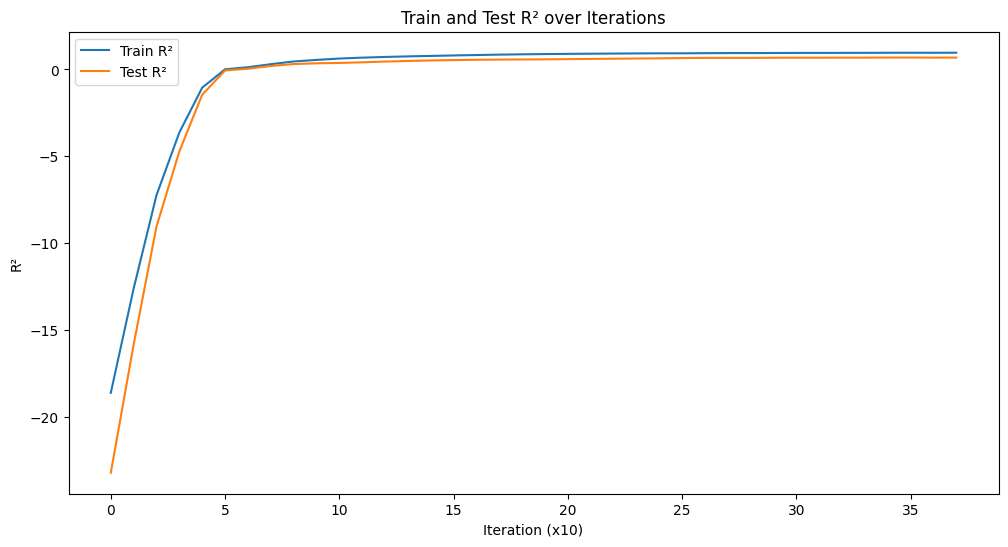

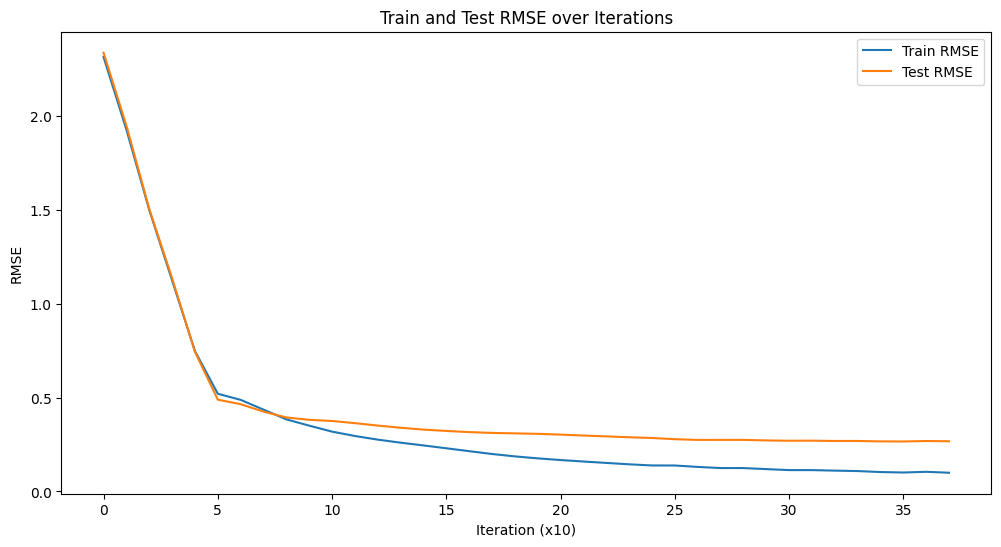

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import random

# Фиксация случайных чисел
def set_seed(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1984)

# Найденные параметры
best_grid = 22
best_k = 15
best_width = [36, 19, 10, 1]  # Добавляем [36] в начало и [1] в конец

# Инициализация модели с лучшими параметрами
best_model = KAN(width=best_width, grid=best_grid, k=best_k)

# Использование оптимизатора Adam
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.00115)

# Шаг 2: Обучение модели с ранней остановкой и сохранением метрик
def train_with_early_stopping(model, train_input, train_label, test_input, test_label, optimizer, steps, target_r2=0.7):
    best_r2 = -np.inf  # Изначально лучший R² = -inf
    train_r2_history = []
    train_rmse_history = []
    test_r2_history = []
    test_rmse_history = []

    for step in range(steps):
        optimizer.zero_grad()
        output = model(train_input)
        loss = torch.nn.MSELoss()(output, train_label)
        loss.backward()
        optimizer.step()

        # Проверка метрик на тренировочной и тестовой выборках каждые 10 шагов
        if step % 10 == 0:
            with torch.no_grad():
                # Предсказания на тренировочной выборке
                train_output = model(train_input)
                train_preds = train_output.detach().numpy()
                train_r2 = r2_score(train_label.numpy(), train_preds)
                train_rmse = np.sqrt(mean_squared_error(train_label.numpy(), train_preds))

                # Предсказания на тестовой выборке
                test_output = model(test_input)
                test_preds = test_output.detach().numpy()
                test_r2 = r2_score(test_label.numpy(), test_preds)
                test_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

                # Сохранение метрик
                train_r2_history.append(train_r2)
                train_rmse_history.append(train_rmse)
                test_r2_history.append(test_r2)
                test_rmse_history.append(test_rmse)

                print(f"Step {step}: Train R² = {train_r2}, Train RMSE = {train_rmse}, Test R² = {test_r2}, Test RMSE = {test_rmse}")

                # Проверка на наилучший результат по R² на тестовой выборке
                if test_r2 > best_r2:
                    best_r2 = test_r2

                # Ранняя остановка, если достигнут желаемый R²
                if best_r2 >= target_r2:
                    print(f"Reached desired R² of {target_r2} at step {step}. Stopping early.")
                    break

    return model, train_r2_history, train_rmse_history, test_r2_history, test_rmse_history

# Шаг 3: Обучение модели с ранней остановкой на 500 шагах
trained_model, train_r2_history, train_rmse_history, test_r2_history, test_rmse_history = train_with_early_stopping(
    best_model, train_input, train_label, test_input, test_label, optimizer, steps=380
)

# Шаг 4: Финальная оценка на тестовых данных
with torch.no_grad():
    test_preds = trained_model(test_input).detach().numpy()
    final_test_r2 = r2_score(test_label.numpy(), test_preds)
    final_test_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

print(f"Final R² on test set: {final_test_r2}")
print(f"Final RMSE on test set: {final_test_rmse}")

# Шаг 5: Визуализация метрик по шагам
plt.figure(figsize=(12, 6))
plt.plot(train_r2_history, label='Train R²')
plt.plot(test_r2_history, label='Test R²')
plt.title('Train and Test R² over Iterations')
plt.xlabel('Iteration (x10)')
plt.ylabel('R²')
plt.legend()
plt.grid(False)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(test_rmse_history, label='Test RMSE')
plt.title('Train and Test RMSE over Iterations')
plt.xlabel('Iteration (x10)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(False)
plt.show()

# Scatter plot: KAN predicted vs actual

<ipython-input-19-33ea540d4a08>:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE bound', linestyle=':')
<ipython-input-19-33ea540d4a08>:35: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--', linestyle=':')


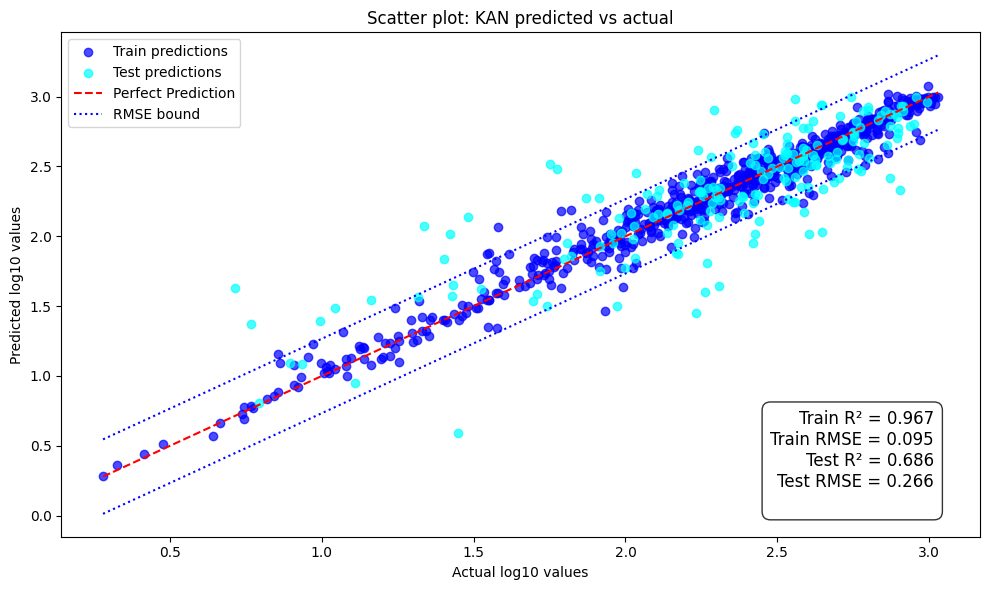

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Получение предсказаний на тренировочной выборке
with torch.no_grad():
    train_preds = trained_model(train_input).detach().numpy()
    test_preds = trained_model(test_input).detach().numpy()

# Финальные метрики
final_train_r2 = r2_score(train_label.numpy(), train_preds)
final_train_rmse = np.sqrt(mean_squared_error(train_label.numpy(), train_preds))
final_test_r2 = r2_score(test_label.numpy(), test_preds)
final_test_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

# Визуализация предсказанных и реальных значений для Train и Test с линиями RMSE
plt.figure(figsize=(10, 6))

# Минимальные и максимальные значения для графика
min_val = min(min(test_label.numpy()), min(train_label.numpy()))
max_val = max(max(test_label.numpy()), max(train_label.numpy()))

# Scatter Plot: Train Data (синие точки)
plt.scatter(train_label.numpy(), train_preds, alpha=0.7, color='blue', label='Train predictions')

# Scatter Plot: Test Data (светло-синие точки)
plt.scatter(test_label.numpy(), test_preds, alpha=0.7, color='cyan', label='Test predictions')

# Идеальная линия предсказания (красная пунктирная линия)
ideal_line = np.linspace(min_val, max_val, 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Perfect Prediction')

# Линии RMSE для тестовой выборки
plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE bound', linestyle=':')
plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--', linestyle=':')

# Финальные метрики для теста и тренировки
metrics_text = (
    f'Train R² = {final_train_r2:.3f}\n'
    f'Train RMSE = {final_train_rmse:.3f}\n'
    f'Test R² = {final_test_r2:.3f}\n'
    f'Test RMSE = {final_test_rmse:.3f}\n'
)

# Добавление текста с метриками
plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'))

# Оформление графика
plt.title('Scatter plot: KAN predicted vs actual')
plt.xlabel('Actual log10 values')
plt.ylabel('Predicted log10 values')
plt.legend(loc='upper left')

# Показать график
plt.tight_layout()
plt.show()

# Метрики для кроссвалидации и валидации

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import random

# Фиксация случайных чисел
def set_seed(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1984)

# Разделение train_input на тренировочную и валидационную выборку (12.5% для валидации)
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.125, random_state=1984)

# Кросс-валидация на 5 фолдах
kf = KFold(n_splits=5, shuffle=True, random_state=1984)

# Найденные параметры
best_grid = 22
best_k = 15
best_width = [36, 19, 10, 1]

# Функция для обучения модели
def train_with_cross_validation(model, train_input, train_label, val_input, val_label, optimizer, steps):
    # Инициализация метрик
    best_r2 = -np.inf
    final_val_r2 = None
    final_val_rmse = None

    for train_index, val_index in kf.split(train_input):
        fold_train_input = train_input[train_index]
        fold_train_label = train_label[train_index]
        fold_val_input = train_input[val_index]
        fold_val_label = train_label[val_index]

        for step in range(steps):
            optimizer.zero_grad()
            output = model(fold_train_input)
            loss = torch.nn.MSELoss()(output, fold_train_label)
            loss.backward()
            optimizer.step()

        # После завершения всех шагов на фолде, вычисляем метрики для валидации
        with torch.no_grad():
            val_output = model(fold_val_input)
            val_preds = val_output.detach().numpy()
            final_val_r2 = r2_score(fold_val_label.numpy(), val_preds)
            final_val_rmse = np.sqrt(mean_squared_error(fold_val_label.numpy(), val_preds))

            # Проверка на лучший результат по R²
            if final_val_r2 > best_r2:
                best_r2 = final_val_r2

    print(f"Final validation R² = {final_val_r2}, Final validation RMSE = {final_val_rmse}")
    return model

# Инициализация модели с лучшими параметрами
best_model = KAN(width=best_width, grid=best_grid, k=best_k)

# Оптимизатор
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.00115)

# Обучение модели с кросс-валидацией
trained_model = train_with_cross_validation(
    best_model, train_input, train_label, val_input, val_label, optimizer, steps=380)

# Финальная оценка на валидационных данных
with torch.no_grad():
    val_preds = trained_model(val_input).detach().numpy()
    final_val_r2 = r2_score(val_label.numpy(), val_preds)
    final_val_rmse = np.sqrt(mean_squared_error(val_label.numpy(), val_preds))

print(f"Final R² on validation set: {final_val_r2}")
print(f"Final RMSE on validation set: {final_val_rmse}")

checkpoint directory created: ./model
saving model version 0.0
Final validation R² = 0.9783521890640259, Final validation RMSE = 0.07644045352935791
Final R² on validation set: 0.22205644845962524
Final RMSE on validation set: 0.4984898865222931


# Поиск конфигураций

In [ ]:
import itertools
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import torch
import optuna

# Генерация всех возможных комбинаций ширины сети
def generate_width_configs(max_number=20, min_length=1, max_length=1):
    width_configs = []
    numbers = list(range(1, max_number + 1))
    for r in range(min_length, max_length + 1):  # Включаем max_length
        for combo in itertools.permutations(numbers, r):
            if all(x > 0 for x in combo):
                width_configs.append(list(combo))
    return width_configs

# Обучение модели с усовершенствованной ранней остановкой
def train_with_early_stopping(model, train_data, test_data, optimizer, steps, loss_fn, min_r2=0.65, patience=10):
    best_r2 = -np.inf  # Лучший R²
    patience_counter = 0  # Счетчик терпения

    for step in range(steps):
        optimizer.zero_grad()
        output = model(train_data['train_input'])
        loss = loss_fn(output, train_data['train_label'])
        loss.backward()
        optimizer.step()

        # Проверяем каждые 10 шагов
        if step % 10 == 0:
            with torch.no_grad():
                test_output = model(test_data['test_input'])
                test_preds = test_output.detach().numpy()
                r2 = r2_score(test_data['test_label'].numpy(), test_preds)

                # Ранняя остановка на основе улучшения R²
                if r2 > best_r2:
                    best_r2 = r2
                    patience_counter = 0  # Сбрасываем счетчик терпения
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"Early stopping at step {step} due to lack of improvement in R².")
                    break

                # Останавливаем обучение, если достигнут желаемый R²
                if best_r2 >= min_r2:
                    print(f"Reached desired R² of {min_r2} at step {step}. Stopping early.")
                    break

    return model

def objective(trial):
    # Выбор гиперпараметров
    grid_val = trial.suggest_categorical('grid', grid_values)
    k_val = trial.suggest_categorical('k', k_values)

    # Преобразование списка конфигураций ширины в строку для совместимости с Optuna
    width_config_str = trial.suggest_categorical('width', width_configs)
    width_config = eval(width_config_str)  # Преобразование строки обратно в список
    width = [36] + width_config + [1]

    try:
        # Инициализация модели
        model = KAN(width=width, grid=grid_val, k=k_val)

        # Использование оптимизатора Adam
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Обучение с ранней остановкой на основе R² и терпения
        model = train_with_early_stopping(model,
                                          {'train_input': train_input, 'train_label': train_label},
                                          {'test_input': test_input, 'test_label': test_label},
                                          optimizer, steps=500, loss_fn=torch.nn.MSELoss())

        # Предсказание на тесте
        test_preds = model(test_input).detach().numpy()

        # Оценка метрики R²
        r2 = r2_score(test_label.numpy(), test_preds)

        # Проверка целевого значения
        if r2 < 0.65:
            raise optuna.exceptions.TrialPruned()  # Прерываем, если R² меньше порога

        return r2

    except Exception as e:
        print(f"Error in trial with grid={grid_val}, k={k_val}, width={width}. Error: {e}")
        raise optuna.exceptions.TrialPruned()

# Определение гиперпараметров для поиска
grid_values = list(range(2, 36))
k_values = list(range(2, 36))
width_configs = [str(config) for config in generate_width_configs(max_number=36, max_length=1)]

# Оптимизация с помощью Optuna
study = optuna.create_study(direction='maximize')  # Изменяем направление оптимизации на максимизацию R²
study.optimize(objective, n_trials=100)

# Получаем лучшие параметры
best_trial = study.best_trial
best_params = best_trial.params

# Повторное обучение с лучшими параметрами
best_model = KAN(width=[36] + eval(best_params['width']) + [1], grid=best_params['grid'], k=best_params['k'])
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)
best_model = train_with_early_stopping(best_model,
                                       {'train_input': train_input, 'train_label': train_label},
                                       {'test_input': test_input, 'test_label': test_label},
                                       optimizer=best_optimizer,
                                       steps=500, loss_fn=torch.nn.MSELoss(),
                                       min_r2=0.5, patience=10)

# Оценка модели на тестовых данных
test_preds = best_model(test_input).detach().numpy()
best_r2 = r2_score(test_label.numpy(), test_preds)
best_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

# Вывод лучших параметров и метрик
print("Best parameters found by Optuna:")
print(best_params)
print(f"Best R² on test set: {best_r2}")
print(f"Best RMSE on test set: {best_rmse}")

[I 2024-09-08 10:05:18,986] A new study created in memory with name: no-name-9c64ac76-7406-4263-9820-c00b1e5955d5


checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 330 due to lack of improvement in R².


[I 2024-09-08 10:16:12,767] Trial 0 pruned. 


Error in trial with grid=27, k=22, width=[[36, 0], [28, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 350 due to lack of improvement in R².


[I 2024-09-08 10:23:30,777] Trial 1 pruned. 


Error in trial with grid=24, k=11, width=[[36, 0], [35, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 10:35:52,797] Trial 2 pruned. 


Error in trial with grid=2, k=27, width=[[36, 0], [26, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 10:39:05,688] Trial 3 pruned. 


Error in trial with grid=3, k=9, width=[[36, 0], [14, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 10:42:37,595] Trial 4 pruned. 


Early stopping at step 320 due to lack of improvement in R².
Error in trial with grid=22, k=4, width=[[36, 0], [24, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 10:53:51,864] Trial 5 pruned. 


Error in trial with grid=18, k=30, width=[[36, 0], [12, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 10:57:59,154] Trial 6 pruned. 


Error in trial with grid=2, k=13, width=[[36, 0], [14, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 10:58:46,763] Trial 7 pruned. 


Error in trial with grid=22, k=4, width=[[36, 0], [2, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 11:03:24,688] Trial 8 pruned. 


Early stopping at step 340 due to lack of improvement in R².
Error in trial with grid=29, k=3, width=[[36, 0], [26, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 11:19:31,412] Trial 9 pruned. 


Error in trial with grid=14, k=32, width=[[36, 0], [18, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 480 due to lack of improvement in R².


[I 2024-09-08 11:32:34,974] Trial 10 pruned. 


Error in trial with grid=23, k=22, width=[[36, 0], [28, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 370 due to lack of improvement in R².


[I 2024-09-08 11:38:47,794] Trial 11 pruned. 


Error in trial with grid=27, k=11, width=[[36, 0], [28, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 350 due to lack of improvement in R².


[I 2024-09-08 11:46:01,764] Trial 12 pruned. 


Error in trial with grid=24, k=11, width=[[36, 0], [35, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 440 due to lack of improvement in R².


[I 2024-09-08 12:05:57,607] Trial 13 pruned. 


Error in trial with grid=27, k=26, width=[[36, 0], [35, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 340 due to lack of improvement in R².


[I 2024-09-08 12:18:09,904] Trial 14 pruned. 


Error in trial with grid=24, k=22, width=[[36, 0], [33, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 12:26:56,299] Trial 15 pruned. 


Error in trial with grid=21, k=31, width=[[36, 0], [9, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 12:38:53,183] Trial 16 pruned. 


Error in trial with grid=9, k=17, width=[[36, 0], [34, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 12:47:31,044] Trial 17 pruned. 


Error in trial with grid=12, k=28, width=[[36, 0], [13, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 12:51:03,950] Trial 18 pruned. 


Error in trial with grid=19, k=19, width=[[36, 0], [6, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 12:53:24,069] Trial 19 pruned. 


Error in trial with grid=10, k=24, width=[[36, 0], [1, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 12:56:00,360] Trial 20 pruned. 


Error in trial with grid=6, k=8, width=[[36, 0], [11, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 12:59:55,066] Trial 21 pruned. 


Error in trial with grid=8, k=27, width=[[36, 0], [4, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 340 due to lack of improvement in R².


[I 2024-09-08 13:12:33,799] Trial 22 pruned. 


Error in trial with grid=35, k=27, width=[[36, 0], [26, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 13:19:24,845] Trial 23 pruned. 


Early stopping at step 430 due to lack of improvement in R².
Error in trial with grid=28, k=16, width=[[36, 0], [20, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 390 due to lack of improvement in R².


[I 2024-09-08 13:31:22,290] Trial 24 pruned. 


Error in trial with grid=2, k=35, width=[[36, 0], [22, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 13:37:03,553] Trial 25 pruned. 


Error in trial with grid=15, k=5, width=[[36, 0], [27, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 13:51:16,854] Trial 26 pruned. 


Error in trial with grid=13, k=29, width=[[36, 0], [23, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 13:59:01,957] Trial 27 pruned. 


Error in trial with grid=11, k=15, width=[[36, 0], [25, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 300 due to lack of improvement in R².


[I 2024-09-08 14:10:31,467] Trial 28 pruned. 


Error in trial with grid=32, k=33, width=[[36, 0], [19, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 14:15:35,779] Trial 29 pruned. 


Early stopping at step 490 due to lack of improvement in R².
Error in trial with grid=26, k=18, width=[[36, 0], [10, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 14:19:35,315] Trial 30 pruned. 


Error in trial with grid=4, k=23, width=[[36, 0], [7, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 14:25:51,605] Trial 31 pruned. 


Error in trial with grid=3, k=7, width=[[36, 0], [29, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 14:30:13,946] Trial 32 pruned. 


Error in trial with grid=5, k=9, width=[[36, 0], [17, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 480 due to lack of improvement in R².
Error in trial with grid=34, k=6, width=[[36, 0], [14, 0], [1, 0]]. Error: 


[I 2024-09-08 14:34:15,755] Trial 33 pruned. 


checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 14:37:59,706] Trial 34 pruned. 


Early stopping at step 430 due to lack of improvement in R².
Error in trial with grid=7, k=2, width=[[36, 0], [21, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 440 due to lack of improvement in R².


[I 2024-09-08 14:48:33,699] Trial 35 pruned. 


Error in trial with grid=20, k=12, width=[[36, 0], [36, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 370 due to lack of improvement in R².


[I 2024-09-08 14:57:50,170] Trial 36 pruned. 


Error in trial with grid=30, k=25, width=[[36, 0], [15, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 15:34:24,532] Trial 37 pruned. 


Error in trial with grid=33, k=34, width=[[36, 0], [30, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 15:36:53,027] Trial 38 pruned. 


Error in trial with grid=25, k=14, width=[[36, 0], [3, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 15:41:01,357] Trial 39 pruned. 


Error in trial with grid=16, k=21, width=[[36, 0], [5, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 15:43:30,439] Trial 40 pruned. 


Error in trial with grid=17, k=9, width=[[36, 0], [8, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Reached desired R² of 0.65 at step 190. Stopping early.


[I 2024-09-08 15:46:18,577] Trial 41 finished with value: 0.6546183689824097 and parameters: {'grid': 22, 'k': 4, 'width': '[31]'}. Best is trial 41 with value: 0.6546183689824097.


checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 350 due to lack of improvement in R².


[I 2024-09-08 15:53:22,667] Trial 42 pruned. 


Error in trial with grid=22, k=10, width=[[36, 0], [32, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 270 due to lack of improvement in R².


[I 2024-09-08 15:57:29,938] Trial 43 pruned. 


Error in trial with grid=31, k=4, width=[[36, 0], [31, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 16:18:21,726] Trial 44 pruned. 


Error in trial with grid=3, k=30, width=[[36, 0], [31, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 16:22:03,570] Trial 45 pruned. 


Early stopping at step 350 due to lack of improvement in R².
Error in trial with grid=27, k=11, width=[[36, 0], [16, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 440 due to lack of improvement in R².


[I 2024-09-08 16:30:41,541] Trial 46 pruned. 


Error in trial with grid=2, k=20, width=[[36, 0], [28, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 16:33:07,062] Trial 47 pruned. 


Early stopping at step 450 due to lack of improvement in R².
Error in trial with grid=24, k=4, width=[[36, 0], [12, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 16:39:56,261] Trial 48 pruned. 


Early stopping at step 480 due to lack of improvement in R².
Error in trial with grid=18, k=22, width=[[36, 0], [14, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 390 due to lack of improvement in R².


[I 2024-09-08 16:54:12,623] Trial 49 pruned. 


Error in trial with grid=22, k=32, width=[[36, 0], [24, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 280 due to lack of improvement in R².


[I 2024-09-08 16:58:13,130] Trial 50 pruned. 


Error in trial with grid=23, k=3, width=[[36, 0], [35, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 17:01:33,754] Trial 51 pruned. 


Early stopping at step 320 due to lack of improvement in R².
Error in trial with grid=29, k=4, width=[[36, 0], [24, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 17:09:07,266] Trial 52 pruned. 


Error in trial with grid=14, k=13, width=[[36, 0], [26, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 17:12:59,398] Trial 53 pruned. 


Error in trial with grid=22, k=27, width=[[36, 0], [2, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 320 due to lack of improvement in R².


[I 2024-09-08 17:19:34,611] Trial 54 pruned. 


Error in trial with grid=27, k=11, width=[[36, 0], [33, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 380 due to lack of improvement in R².


[I 2024-09-08 17:35:19,008] Trial 55 pruned. 


Error in trial with grid=22, k=26, width=[[36, 0], [35, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 17:44:00,484] Trial 56 pruned. 


Error in trial with grid=21, k=31, width=[[36, 0], [9, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 17:53:11,761] Trial 57 pruned. 


Error in trial with grid=24, k=22, width=[[36, 0], [18, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 490 due to lack of improvement in R².


[I 2024-09-08 18:01:26,199] Trial 58 pruned. 


Error in trial with grid=2, k=17, width=[[36, 0], [28, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:06:33,611] Trial 59 pruned. 


Error in trial with grid=9, k=28, width=[[36, 0], [6, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:23:22,007] Trial 60 pruned. 


Error in trial with grid=10, k=24, width=[[36, 0], [34, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:32:33,897] Trial 61 pruned. 


Error in trial with grid=12, k=30, width=[[36, 0], [12, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:38:18,534] Trial 62 pruned. 


Error in trial with grid=18, k=19, width=[[36, 0], [13, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:41:09,751] Trial 63 pruned. 


Early stopping at step 480 due to lack of improvement in R².
Error in trial with grid=19, k=4, width=[[36, 0], [14, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:41:42,599] Trial 64 pruned. 


Error in trial with grid=3, k=8, width=[[36, 0], [1, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:49:43,158] Trial 65 pruned. 


Error in trial with grid=8, k=16, width=[[36, 0], [26, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 18:52:24,360] Trial 66 pruned. 


Error in trial with grid=6, k=9, width=[[36, 0], [11, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 19:12:01,151] Trial 67 pruned. 


Error in trial with grid=28, k=35, width=[[36, 0], [20, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 19:16:43,367] Trial 68 pruned. 


Error in trial with grid=13, k=29, width=[[36, 0], [4, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 19:20:10,999] Trial 69 pruned. 


Early stopping at step 340 due to lack of improvement in R².
Error in trial with grid=35, k=5, width=[[36, 0], [22, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 19:36:05,086] Trial 70 pruned. 


Error in trial with grid=18, k=27, width=[[36, 0], [27, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 19:39:47,651] Trial 71 pruned. 


Error in trial with grid=2, k=13, width=[[36, 0], [14, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 19:47:49,778] Trial 72 pruned. 


Error in trial with grid=15, k=15, width=[[36, 0], [25, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 19:53:31,802] Trial 73 pruned. 


Early stopping at step 310 due to lack of improvement in R².
Error in trial with grid=34, k=18, width=[[36, 0], [19, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 280 due to lack of improvement in R².


[I 2024-09-08 20:08:57,350] Trial 74 pruned. 


Error in trial with grid=32, k=33, width=[[36, 0], [31, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:16:54,491] Trial 75 pruned. 


Error in trial with grid=11, k=30, width=[[36, 0], [10, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:22:48,125] Trial 76 pruned. 


Error in trial with grid=4, k=6, width=[[36, 0], [29, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:32:27,229] Trial 77 pruned. 


Error in trial with grid=5, k=23, width=[[36, 0], [24, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:36:17,837] Trial 78 pruned. 


Error in trial with grid=7, k=11, width=[[36, 0], [15, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:38:48,933] Trial 79 pruned. 


Error in trial with grid=2, k=7, width=[[36, 0], [12, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:41:30,468] Trial 80 pruned. 


Early stopping at step 300 due to lack of improvement in R².
Error in trial with grid=26, k=2, width=[[36, 0], [23, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:42:13,729] Trial 81 pruned. 


Error in trial with grid=22, k=4, width=[[36, 0], [2, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:46:22,314] Trial 82 pruned. 


Early stopping at step 370 due to lack of improvement in R².
Error in trial with grid=30, k=12, width=[[36, 0], [17, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 20:47:50,308] Trial 83 pruned. 


Early stopping at step 450 due to lack of improvement in R².
Error in trial with grid=20, k=4, width=[[36, 0], [7, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 360 due to lack of improvement in R².


[I 2024-09-08 21:02:15,452] Trial 84 pruned. 


Error in trial with grid=22, k=25, width=[[36, 0], [36, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 310 due to lack of improvement in R².


[I 2024-09-08 21:21:58,464] Trial 85 pruned. 


Error in trial with grid=27, k=34, width=[[36, 0], [30, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 380 due to lack of improvement in R².


[I 2024-09-08 21:30:57,928] Trial 86 pruned. 


Error in trial with grid=25, k=14, width=[[36, 0], [35, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 21:36:37,551] Trial 87 pruned. 


Early stopping at step 380 due to lack of improvement in R².
Error in trial with grid=33, k=13, width=[[36, 0], [21, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 400 due to lack of improvement in R².


[I 2024-09-08 21:47:36,146] Trial 88 pruned. 


Error in trial with grid=24, k=22, width=[[36, 0], [28, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 21:51:41,673] Trial 89 pruned. 


Error in trial with grid=31, k=21, width=[[36, 0], [5, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 21:53:45,692] Trial 90 pruned. 


Error in trial with grid=3, k=10, width=[[36, 0], [8, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 21:57:25,874] Trial 91 pruned. 


Early stopping at step 340 due to lack of improvement in R².
Error in trial with grid=29, k=3, width=[[36, 0], [26, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 22:00:49,160] Trial 92 pruned. 


Early stopping at step 330 due to lack of improvement in R².
Error in trial with grid=17, k=3, width=[[36, 0], [26, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 22:01:56,776] Trial 93 pruned. 


Error in trial with grid=22, k=9, width=[[36, 0], [2, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 22:08:07,319] Trial 94 pruned. 


Error in trial with grid=2, k=4, width=[[36, 0], [32, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 22:12:51,474] Trial 95 pruned. 


Error in trial with grid=29, k=27, width=[[36, 0], [3, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 22:19:04,873] Trial 96 pruned. 


Error in trial with grid=16, k=20, width=[[36, 0], [14, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 490 due to lack of improvement in R².


[I 2024-09-08 22:28:56,785] Trial 97 pruned. 


Error in trial with grid=23, k=26, width=[[36, 0], [16, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0


[I 2024-09-08 22:44:05,464] Trial 98 pruned. 


Error in trial with grid=14, k=30, width=[[36, 0], [24, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Early stopping at step 320 due to lack of improvement in R².


[I 2024-09-08 22:50:23,035] Trial 99 pruned. 


Error in trial with grid=27, k=11, width=[[36, 0], [33, 0], [1, 0]]. Error: 
checkpoint directory created: ./model
saving model version 0.0
Reached desired R² of 0.5 at step 110. Stopping early.
Best parameters found by Optuna:
{'grid': 22, 'k': 4, 'width': '[31]'}
Best R² on test set: 0.5133224073166813
Best RMSE on test set: 0.3315507173538208


Найдено ранее - неполохо:


*  Configuration below threshold: **R² = 0.6288957700769227,** RMSE = 0.28951913118362427, Grid = 2, k = 3, Width = [[36, 0], [4, 0], [11, 0], [1, 0]]
* Configuration below threshold: R² = 0.5615338691288727, Grid = 2, k = 3, Width = [[36, 0], [2, 0], [9, 0], [1, 0]]
*  Configuration below threshold: R² = 0.46105551926175214, Grid = 2, k = 3, Width = [[36, 0], [2, 0], [11, 0], [1, 0]]

## Проверка Step 380: R² = 0.6833

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import random

# Фиксация случайных чисел
def set_seed(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1984)

# Предполагается, что KAN, train_input, train_label, test_input, test_label уже определены

# Найденные параметры
best_grid = 22
best_k = 15
best_width = [36, 19, 10, 1]  # Добавляем [36] в начало и [1] в конец

# Инициализация модели с лучшими параметрами
best_model = KAN(width=best_width, grid=best_grid, k=best_k)

# Использование оптимизатора Adam (такой как в процессе поиска Optuna)
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.00115)

# Функция для обучения модели с ранней остановкой
def train_with_early_stopping(model, train_input, train_label, test_input, test_label, optimizer, steps, target_r2=0.7):
    best_r2 = -np.inf  # Изначально лучший R² = -inf

    for step in range(steps):
        optimizer.zero_grad()
        output = model(train_input)
        loss = torch.nn.MSELoss()(output, train_label)
        loss.backward()
        optimizer.step()

        # Проверяем R² на тесте каждые 10 шагов
        if step % 10 == 0:
            with torch.no_grad():
                test_output = model(test_input)
                test_preds = test_output.detach().numpy()
                r2 = r2_score(test_label.numpy(), test_preds)
                print(f"Step {step}: R² = {r2}")

                if r2 > best_r2:
                    best_r2 = r2

                # Ранняя остановка, если достигнут желаемый R²
                if best_r2 >= target_r2:
                    print(f"Reached desired R² of {target_r2} at step {step}. Stopping early.")
                    break

    return model

# Обучение модели (270 шагов с ранней остановкой)
trained_model = train_with_early_stopping(best_model, train_input, train_label, test_input, test_label, optimizer, steps=500)

# Оценка на тестовых данных
with torch.no_grad():
    test_preds = trained_model(test_input).detach().numpy()
    best_r2 = r2_score(test_label.numpy(), test_preds)
    best_rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

print(f"Final R² on test set: {best_r2}")
print(f"Final RMSE on test set: {best_rmse}")

checkpoint directory created: ./model
saving model version 0.0
Step 0: R² = -23.210226912810864
Step 10: R² = -15.833164916983662
Step 20: R² = -9.041570546880177
Step 30: R² = -4.716498619726252
Step 40: R² = -1.4524157808769487
Step 50: R² = -0.05990010466913498
Step 60: R² = 0.042054602444629885
Step 70: R² = 0.19826603430017786
Step 80: R² = 0.311116164648471
Step 90: R² = 0.3547802848307442
Step 100: R² = 0.3750700872661382
Step 110: R² = 0.4127332658802819
Step 120: R² = 0.4539549080187453
Step 130: R² = 0.48895770659958304
Step 140: R² = 0.5187086125099012
Step 150: R² = 0.5390013076389519
Step 160: R² = 0.5565663674689236
Step 170: R² = 0.5686450203034034
Step 180: R² = 0.5752492923712769
Step 190: R² = 0.5821128356092842
Step 200: R² = 0.5935795089531506
Step 210: R² = 0.6064631455392333
Step 220: R² = 0.6181193847105554
Step 230: R² = 0.6300897852009149
Step 240: R² = 0.6403578878824482
Step 250: R² = 0.6561921578889753
Step 260: R² = 0.6656074774617288
Step 270: R² = 0.66547

# SHAP

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 34.6 MB/s eta 0:00:00


Shape of SHAP values: (196, 36, 1)
Shape of test data: (196, 36)


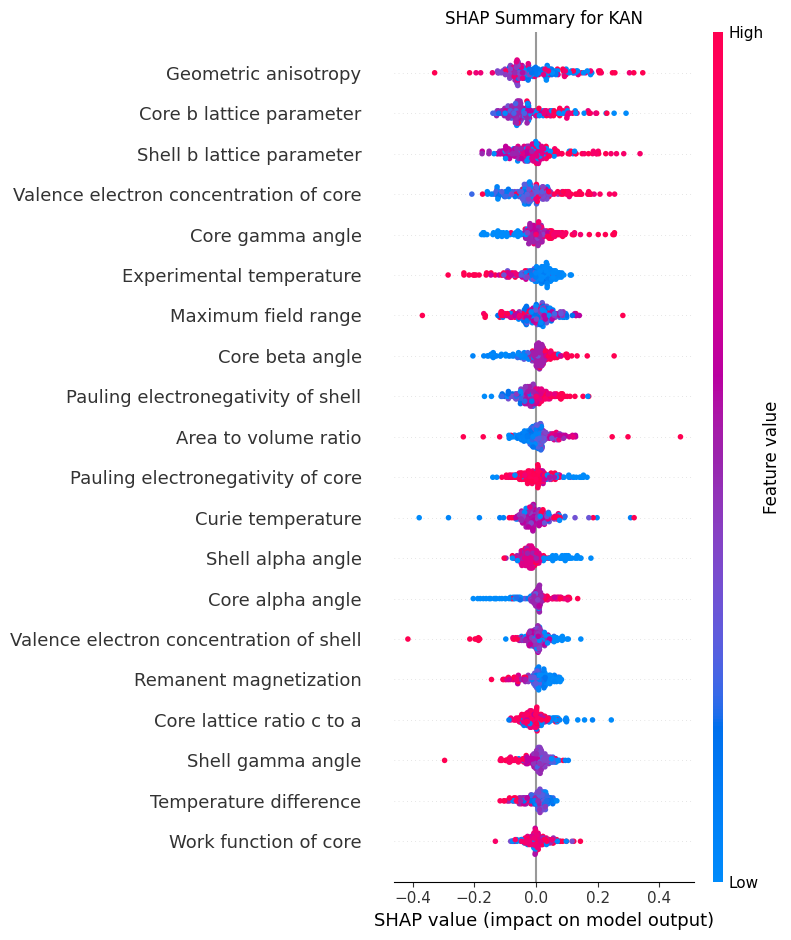

In [ ]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# Переход в режим оценки модели
best_model.eval()

# Преобразование входных данных в формат numpy
X_train_np = train_input.detach().cpu().numpy()
X_test_np = test_input.detach().cpu().numpy()

# Преобразование данных обратно в тензоры для SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float)
test_tensor = torch.tensor(X_test_np, dtype=torch.float)

# Создаем SHAP объяснитель
explainer = shap.GradientExplainer(best_model, train_tensor)

# Вычисляем SHAP значения для тестовых данных
shap_values = explainer.shap_values(test_tensor)

# Преобразуем SHAP значения в numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # Используем первый элемент для регрессии
else:
    shap_values_np = np.array(shap_values)

# Проверка размерностей
print("Shape of SHAP values:", shap_values_np.shape)
print("Shape of test data:", X_test_np.shape)

# Если SHAP значения многомерные (samples, features, outputs), усредняем по выходам
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Определение правильного количества признаков
num_features = X_train_np.shape[1]
feature_names = [f'Feature {i}' for i in range(num_features)]

# Словарь для переименования признаков
rename_dict = {
    'Feature 0': 'Area to volume ratio',
    'Feature 1': 'Maximum field range',
    'Feature 2': 'Curie temperature',
    'Feature 3': 'Experimental temperature',
    'Feature 4': 'Saturation magnetization',
    'Feature 5': 'Coercivity',
    'Feature 6': 'Remanent magnetization',
    'Feature 7': 'Exchange bias shift',
    'Feature 8': 'Exchange shift direction',
    'Feature 9': 'Vertical shift',
    'Feature 10': 'Vertical shift direction',
    'Feature 11': 'Magnetic field strength',
    'Feature 12': 'Sphericity',
    'Feature 13': 'Geometric anisotropy',
    'Feature 14': 'Core b lattice parameter',
    'Feature 15': 'Core alpha angle',
    'Feature 16': 'Core beta angle',
    'Feature 17': 'Core gamma angle',
    'Feature 18': 'Shell b lattice parameter',
    'Feature 19': 'Shell alpha angle',
    'Feature 20': 'Shell beta angle',
    'Feature 21': 'Shell gamma angle',
    'Feature 22': 'Magnetic ion ratio',
    'Feature 23': 'Temperature difference',
    'Feature 24': 'Exchange stiffness coefficient',
    'Feature 25': 'Core lattice ratio с to a',
    'Feature 26': 'Pauling electronegativity of core',
    'Feature 27': 'Pauling electronegativity of shell',
    'Feature 28': 'Valence electron concentration of core',
    'Feature 29': 'Work function of core',
    'Feature 30': 'Valence electron concentration of shell',
    'Feature 31': 'Work function of shell',
    'Feature 32': 'Pauling electronegativity difference of core',
    'Feature 33': 'Valence electron concentration difference of core',
    'Feature 34': 'Work function difference of core',
    'Feature 35': 'Pauling electronegativity difference of shell',
    'Feature 36': 'Valence electron concentration difference of shell',
    'Feature 37': 'Work function difference of shell'
}

# Переход в режим оценки модели
best_model.eval()

# Преобразование входных данных в формат numpy
X_train_np = train_input.detach().cpu().numpy()
X_test_np = test_input.detach().cpu().numpy()

# Удаление признака 'Exchange bias shift' (Feature 7)
exclude_feature = 'Feature 7'
exclude_index = [i for i, feature in enumerate(feature_names) if feature == exclude_feature]

if exclude_index:
    X_train_np = np.delete(X_train_np, exclude_index, axis=1)  # Удаление из данных
    X_test_np = np.delete(X_test_np, exclude_index, axis=1)    # Удаление из тестовых данных

# Преобразование данных обратно в тензоры для SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float)
test_tensor = torch.tensor(X_test_np, dtype=torch.float)

# Создаем SHAP объяснитель
explainer = shap.GradientExplainer(best_model, train_tensor)

# Вычисляем SHAP значения для тестовых данных
shap_values = explainer.shap_values(test_tensor)

# Преобразуем SHAP значения в numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # Используем первый элемент для регрессии
else:
    shap_values_np = np.array(shap_values)

# Проверка размерностей
print("Shape of SHAP values:", shap_values_np.shape)
print("Shape of test data:", X_test_np.shape)

# Если SHAP значения многомерные (samples, features, outputs), усредняем по выходам
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Обновление списка признаков без исключенного признака
feature_names_renamed = [rename_dict.get(f, f) for i, f in enumerate(feature_names) if i not in exclude_index]

# Проверка корректности длины имен признаков
if len(feature_names_renamed) != X_test_np.shape[1]:
    raise ValueError("The number of renamed features does not match the number of features in the data.")

# Создание фигуры и оси перед построением графика SHAP
plt.figure(figsize=(10, 6))

# Построение SHAP summary plot с переименованными признаками без 'Exchange bias shift'
shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)

# Добавление заголовка через matplotlib
plt.title("SHAP Summary for KAN")
plt.tight_layout()  # Для предотвращения обрезки графика
plt.show()